#https://www.kaggle.com/nadare/eda-feature-engineering-and-modeling-4th-359
#https://www.kaggle.com/arateris/2-layer-k-fold-learning-forest-cover

Another feature engineer learning from others

In [1]:
# For the feature engineer, there are something needed to be checked for example, if there is some value missing?
# The distribution for the data

In [115]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc


from sklearn.neighbors import KNeighborsClassifier

from time import time

from collections import Counter
from itertools import combinations

from sklearn.model_selection import cross_val_score,cross_validate, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from mlxtend.classifier import StackingCVClassifier, StackingClassifier
# import lightgbm
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from tqdm import tqdm

from scipy.stats import gaussian_kde


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
#import the data
train_path='/home/ubuntu/learn-with-other-kaggle/data/train.csv'
test_path='/home/ubuntu/learn-with-other-kaggle/data/test.csv'

train_data=pd.read_csv(train_path, index_col = 'Id')
test_data=pd.read_csv(test_path, index_col = 'Id')

In [5]:
# no missing data
print(train_data.isnull().any())
print(test_data.isnull().any())

Elevation                             False
Aspect                                False
Slope                                 False
Horizontal_Distance_To_Hydrology      False
Vertical_Distance_To_Hydrology        False
Horizontal_Distance_To_Roadways       False
Hillshade_9am                         False
Hillshade_Noon                        False
Hillshade_3pm                         False
Horizontal_Distance_To_Fire_Points    False
Wilderness_Area1                      False
Wilderness_Area2                      False
Wilderness_Area3                      False
Wilderness_Area4                      False
Soil_Type1                            False
Soil_Type2                            False
Soil_Type3                            False
Soil_Type4                            False
Soil_Type5                            False
Soil_Type6                            False
Soil_Type7                            False
Soil_Type8                            False
Soil_Type9                      

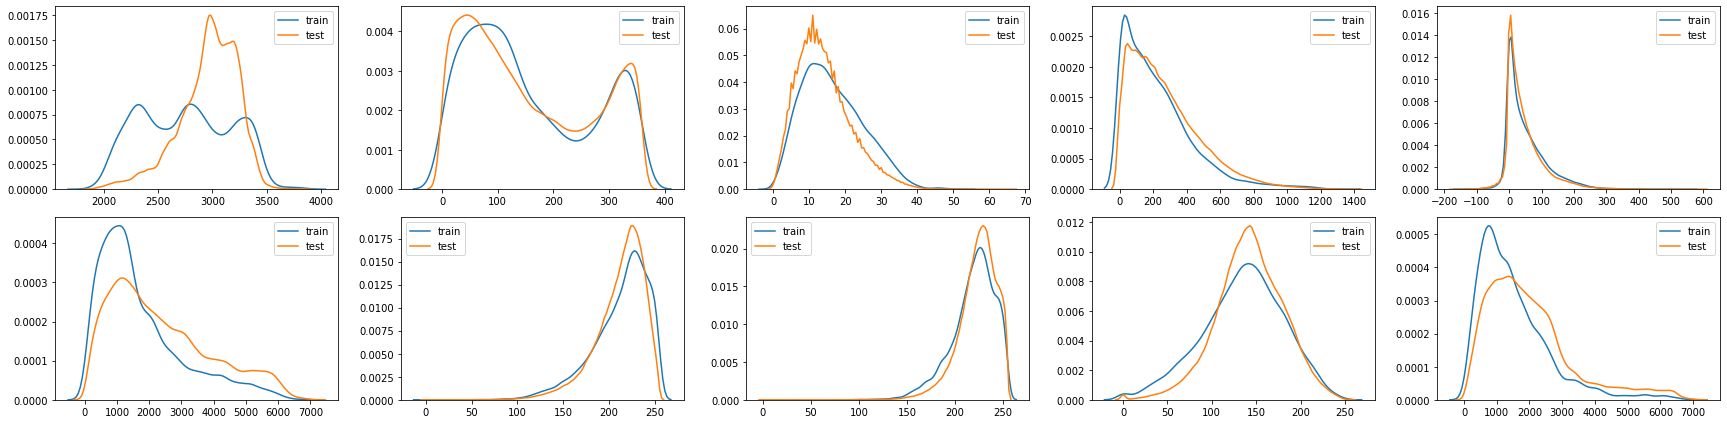

In [6]:
#check the distribution for the features 1-10 which is the linear feature
fig,axs = plt.subplots(2,5,figsize=(24,6))
axs = axs.flatten()

for i, (axs, feature) in enumerate(zip(axs, train_data.columns[0:10])):
    sns.kdeplot(train_data[feature], label='train', ax=axs)
    sns.kdeplot(test_data[feature], label='test', ax=axs)
plt.tight_layout()

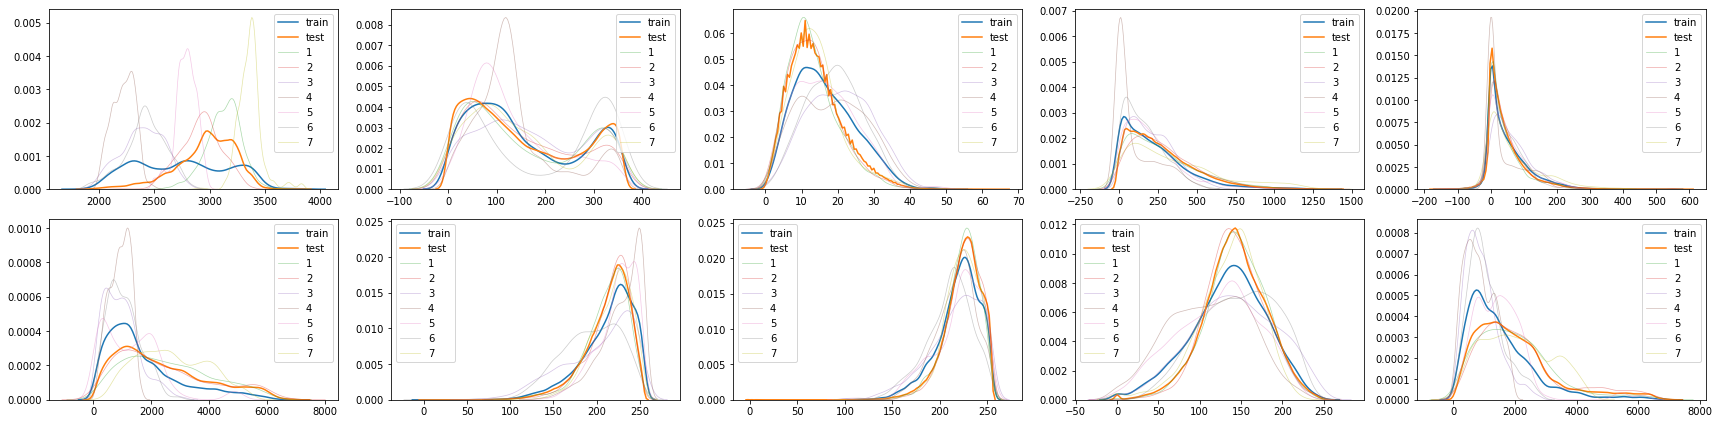

In [7]:
#check the distribution with cover class there
# based on the figure below, the differece from the elevation should be caused by the percentage different between test
# and train
fig,axs = plt.subplots(2,5,figsize=(24,6))
axs = axs.flatten()


for i, (axs, feature) in enumerate(zip(axs, train_data.columns[0:10])):
    sns.kdeplot(train_data[feature], label='train', ax=axs)
    sns.kdeplot(test_data[feature], label='test', ax=axs)
    for ct in range(1,8):
        sns.kdeplot(train_data[train_data['Cover_Type']==ct][feature],label=ct, alpha=0.4, lw = 0.7, ax=axs)
plt.tight_layout()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


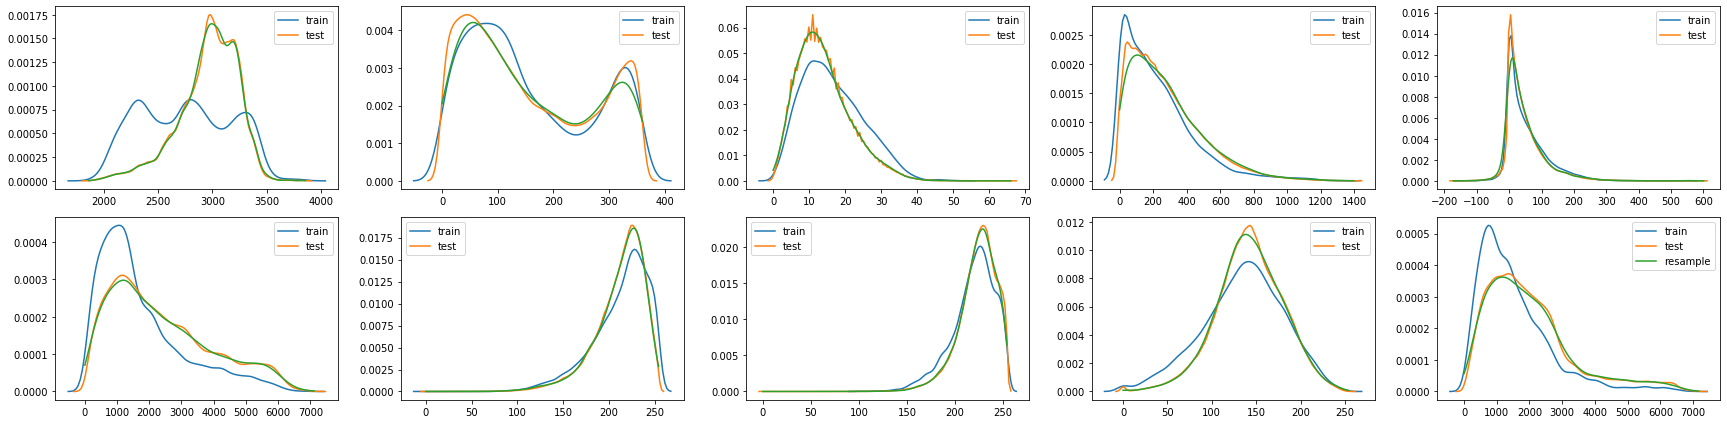

In [8]:
# We re-sample the train data with the percentage and see if the distribution will be the similar
# the type_ratio is gotten by submitting the predict with all the same type repeatly
# then if we re-weight the result using the weight, then we can see the outline almost the same as test
# In summary, the distribute difference between test and train in the elevation is caused by the sample 

type_ratio = np.array([0.37053, 0.49681, 0.05936, 0.00103, 0.01295, 0.02687, 0.03242])


fig,axs = plt.subplots(2,5,figsize=(24,6))
axs = axs.flatten()

for i, (axs, feature) in enumerate(zip(axs, train_data.columns[0:10])):
    sns.kdeplot(train_data[feature], label='train', ax=axs)
    sns.kdeplot(test_data[feature], label='test', ax=axs)
    min_ = min(train_data[feature].min(), test_data[feature].min())
    max_ = max(train_data[feature].max(), test_data[feature].max())
    
    X = np.linspace(min_, max_, 1000)
    y = np.zeros(1000)
    for ct in range(1,8):
        y += gaussian_kde(train_data[train_data['Cover_Type']==ct][feature])(X)*type_ratio[ct-1]
    axs.plot(X,y,label="resample")
    plt.legend()
plt.tight_layout()

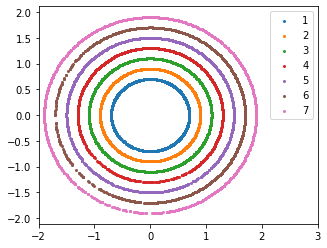

In [9]:
# aspect is the angle used for the field, we can change it to sin and cos which will be good to see the distribute
# every type looks have a circle, so there is no preference for the aspect
sin_ = np.sin(np.pi*train_data['Aspect']/180)
cos_ = np.cos(np.pi*train_data['Aspect']/180)

plt.figure(figsize=(5,4))
for ct in range(1,8):
    r = (0.5+0.2*ct)
    plt.scatter(cos_[train_data['Cover_Type']==ct]*r, sin_[train_data['Cover_Type']==ct]*r, s=4,label=ct)
plt.xlim(-2,3)
plt.legend()

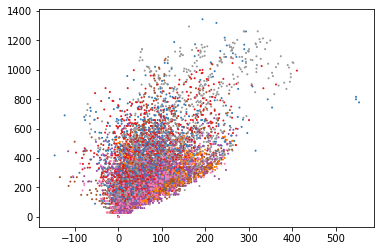

In [10]:
# review the feature of hydrology
hydro_h = train_data['Horizontal_Distance_To_Hydrology']
hydro_v = train_data['Vertical_Distance_To_Hydrology']

plt.scatter(hydro_v, hydro_h, s=1, c=train_data['Cover_Type'],cmap="Set1",alpha=3)

/home/ubuntu/anaconda3/envs/py36_sklearn/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/ubuntu/anaconda3/envs/py36_sklearn/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


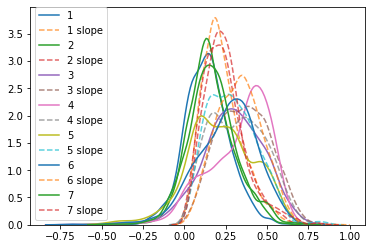

In [11]:
# the arctan value looks have some difference between each other
for ct in range(1,8):
    sns.kdeplot(np.arctan(hydro_v[train_data['Cover_Type']==ct]/hydro_h[train_data['Cover_Type']==ct]), label=ct)
    sns.kdeplot(train_data[train_data['Cover_Type']==ct]['Slope']*np.pi/180,label=str(ct)+" slope", ls="--", alpha=0.7)

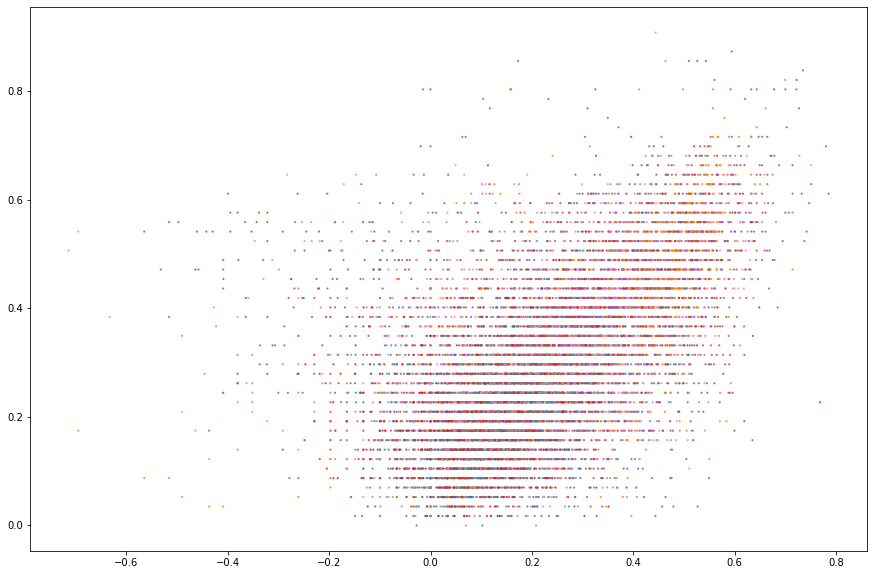

In [12]:
# baed on my understanding, this is to check if there is linear relationship between slope and arctan, if there is, then
# the tan has no much meaning, here we can see its not very obviously, so arctan is good feature
plt.figure(figsize=(15,10))
plt.scatter(np.arctan(hydro_v/hydro_h), train_data['Slope']*np.pi/180, c = train_data['Cover_Type'], cmap='Set1', 
            s = 1.5,
            alpha=0.7)



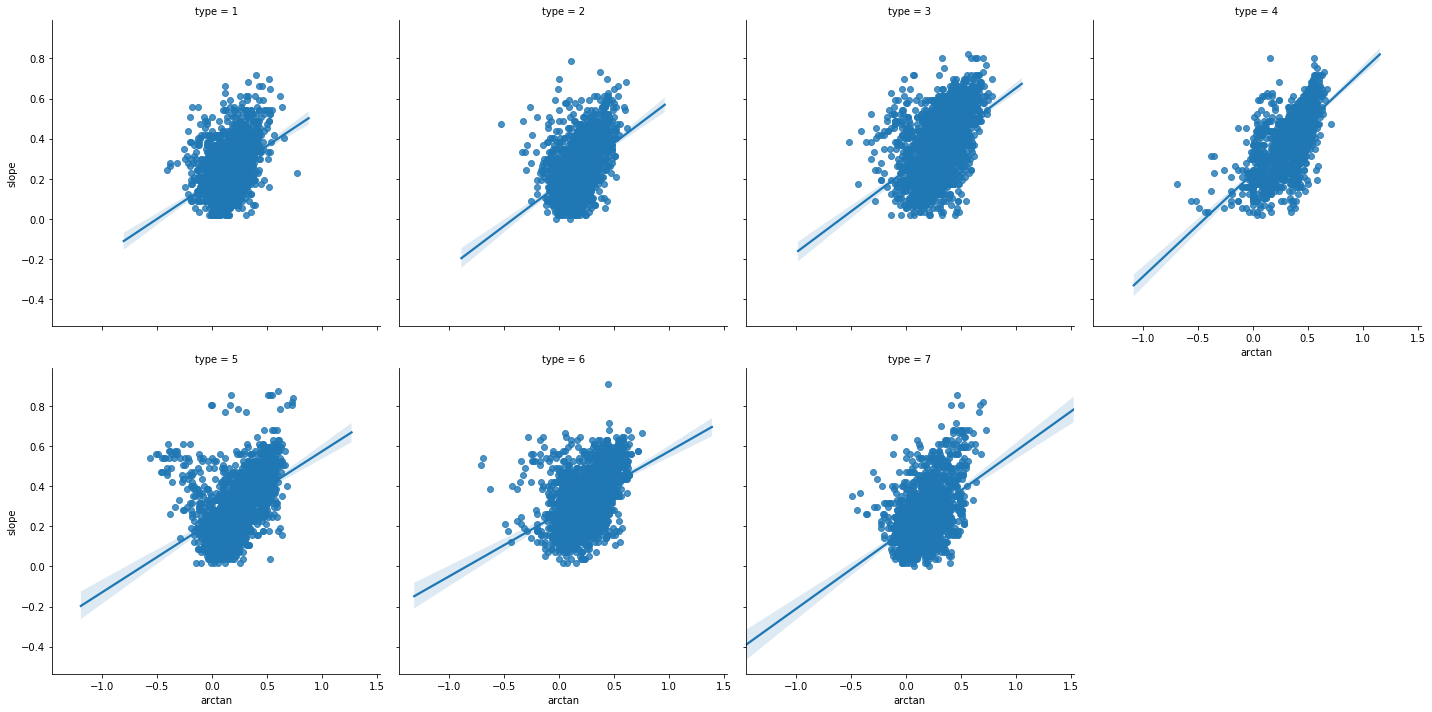

In [13]:
preview = train_data.copy()
preview['type']=train_data['Cover_Type']
preview['slope']=train_data['Slope']*np.pi/180
preview['arctan']=np.arctan(hydro_v/hydro_h)
sns.lmplot(x='arctan', y='slope', col='type', col_wrap=4,data=preview)

/home/ubuntu/anaconda3/envs/py36_sklearn/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='pie')` instead of `Series.plot('pie',)`.
  from ipykernel import kernelapp as app


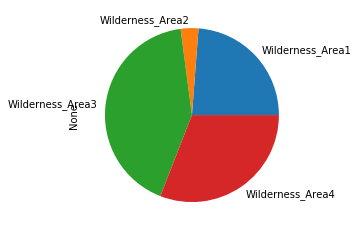

In [14]:
# next, check the Wilderness_Area
train_data.filter(regex='Wilder').sum(axis=0).plot('pie')

In [15]:
train_data.filter(regex='Wilder').sum()

Wilderness_Area1    3597
Wilderness_Area2     499
Wilderness_Area3    6349
Wilderness_Area4    4675
dtype: int64

/home/ubuntu/anaconda3/envs/py36_sklearn/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='pie', ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f901995f080>)` instead of `Series.plot('pie', <matplotlib.axes._subplots.AxesSubplot object at 0x7f901995f080>)`.
/home/ubuntu/anaconda3/envs/py36_sklearn/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='pie', ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f90197c5550>)` instead of `Series.plot('pie', <matplotlib.axes._subplots.AxesSubplot object at 0x7f90197c5550>)`.
/home/ubuntu/anaconda3/envs/py36_sklearn/lib/python3.6/site-packages/ipykernel/__main__.

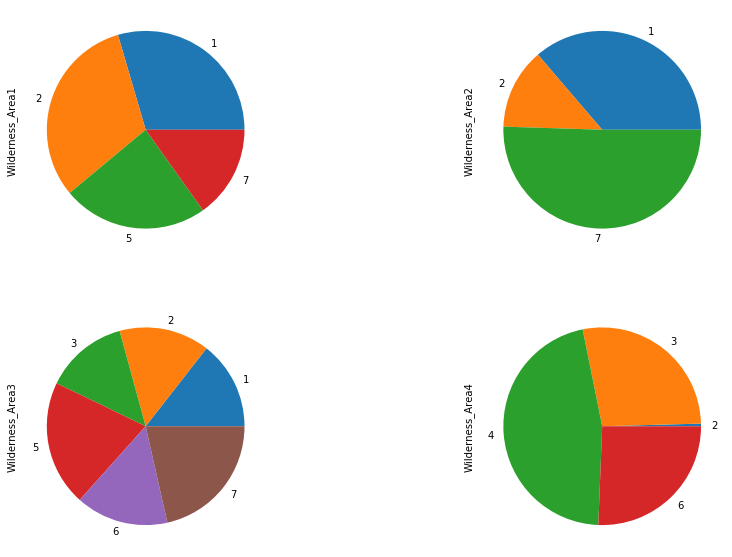

In [16]:
# for different widerness area, there are different types, so good feature to keep
fig,axs = plt.subplots(2,2, figsize=(15,10))
for widerness, axs in zip(train_data.filter(regex='Wilder').columns, axs.flatten()):
    axs.figure
    train_data[train_data[widerness]==1].groupby('Cover_Type').count()[widerness].plot('pie', axs)

In [17]:
for i, column in enumerate(train_data.columns):
    print(i, column)

0 Elevation
1 Aspect
2 Slope
3 Horizontal_Distance_To_Hydrology
4 Vertical_Distance_To_Hydrology
5 Horizontal_Distance_To_Roadways
6 Hillshade_9am
7 Hillshade_Noon
8 Hillshade_3pm
9 Horizontal_Distance_To_Fire_Points
10 Wilderness_Area1
11 Wilderness_Area2
12 Wilderness_Area3
13 Wilderness_Area4
14 Soil_Type1
15 Soil_Type2
16 Soil_Type3
17 Soil_Type4
18 Soil_Type5
19 Soil_Type6
20 Soil_Type7
21 Soil_Type8
22 Soil_Type9
23 Soil_Type10
24 Soil_Type11
25 Soil_Type12
26 Soil_Type13
27 Soil_Type14
28 Soil_Type15
29 Soil_Type16
30 Soil_Type17
31 Soil_Type18
32 Soil_Type19
33 Soil_Type20
34 Soil_Type21
35 Soil_Type22
36 Soil_Type23
37 Soil_Type24
38 Soil_Type25
39 Soil_Type26
40 Soil_Type27
41 Soil_Type28
42 Soil_Type29
43 Soil_Type30
44 Soil_Type31
45 Soil_Type32
46 Soil_Type33
47 Soil_Type34
48 Soil_Type35
49 Soil_Type36
50 Soil_Type37
51 Soil_Type38
52 Soil_Type39
53 Soil_Type40
54 Cover_Type


0.0
2160.0
4320.0
6480.0
8640.0
10800.0
12960.0
15120.0


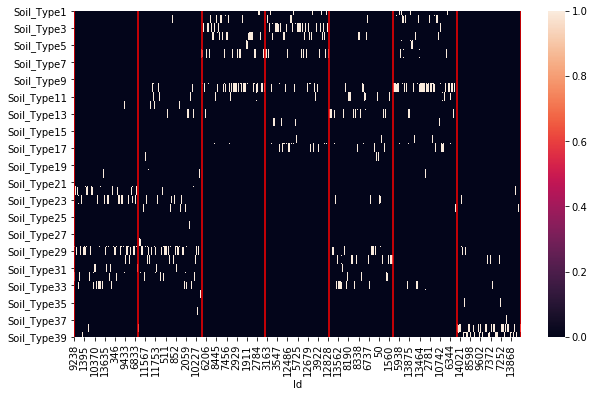

In [18]:
#for the heatmap, we will separete the points into 8 parts, every part will have heatmap for the soil type
#actually we can see different type, the soil type has some different
# I reviewed this using the distplot, however obviously this heatmap is much better and has more meanful pic
plt.figure(figsize=(10,6))
sns.heatmap(train_data.iloc[:,-41:].sort_values(by="Cover_Type").iloc[:, :-1].T)
for i in np.linspace(0, train_data.shape[0], 8)[0:]:
    print(i)
    plt.axvline(i, c="r")

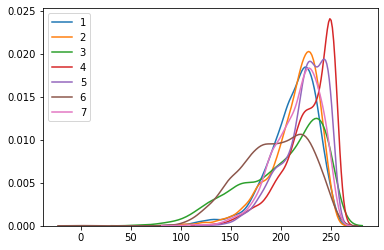

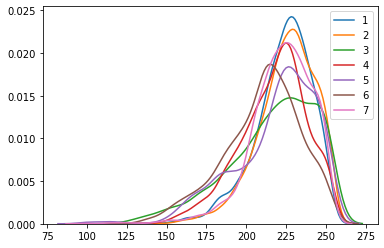

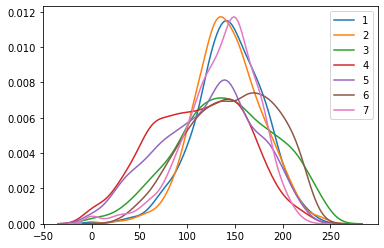

In [19]:
for shade in train_data.filter(regex='Hillshade').columns:
    plt.figure()
    for ct in range(1,8):
        sns.kdeplot(train_data[train_data['Cover_Type']==ct][shade], label=ct)

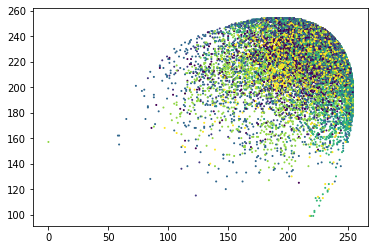

In [21]:
plt.scatter(train_data['Hillshade_9am'], train_data['Hillshade_Noon'], c = train_data['Cover_Type'], s = 1)

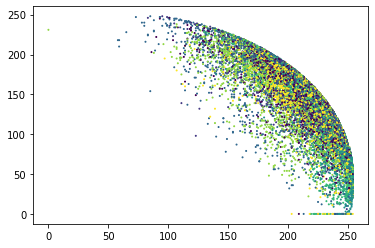

In [138]:
plt.scatter(train_data['Hillshade_9am'], train_data['Hillshade_3pm'], c = train_data['Cover_Type'], s = 1)

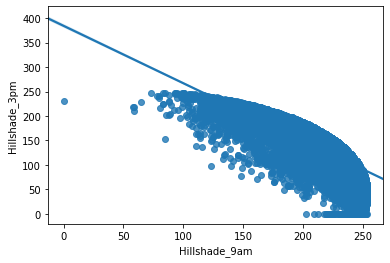

In [25]:
sns.regplot(train_data['Hillshade_9am'], train_data['Hillshade_3pm'])

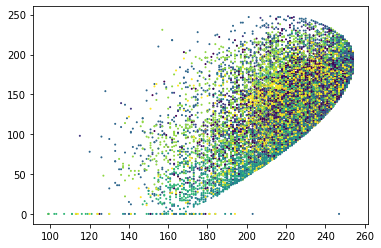

In [23]:
plt.scatter(train_data['Hillshade_Noon'], train_data['Hillshade_3pm'], c = train_data['Cover_Type'], s = 1)

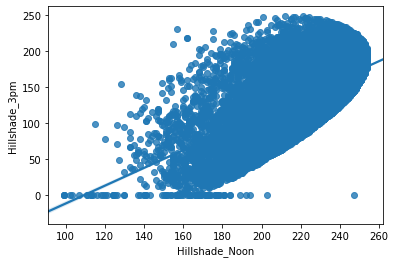

In [24]:
sns.regplot(train_data['Hillshade_Noon'], train_data['Hillshade_3pm'])

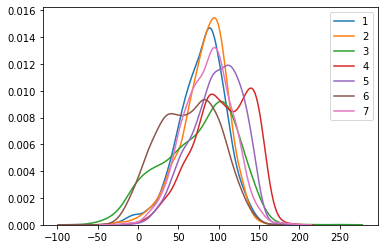

In [27]:
for ct in range(1,8):
    shad_diff = train_data['Hillshade_Noon']-train_data['Hillshade_3pm']
    sns.kdeplot(shad_diff[train_data['Cover_Type']==ct], label=ct)

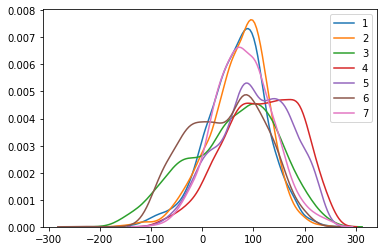

In [28]:
for ct in range(1,8):
    shad_diff = train_data['Hillshade_9am']-train_data['Hillshade_3pm']
    sns.kdeplot(shad_diff[train_data['Cover_Type']==ct], label=ct)

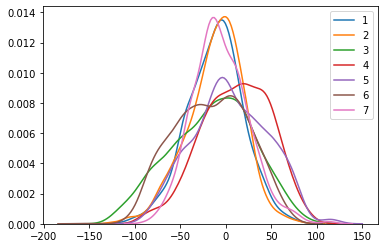

In [29]:
for ct in range(1,8):
    shad_diff = train_data['Hillshade_9am']-train_data['Hillshade_Noon']
    sns.kdeplot(shad_diff[train_data['Cover_Type']==ct], label=ct)

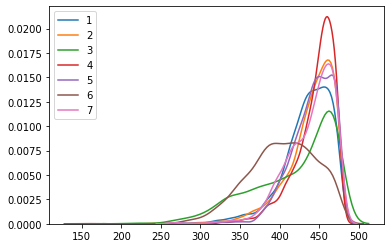

In [30]:
for ct in range(1,8):
    shad_diff = train_data['Hillshade_9am']+train_data['Hillshade_Noon']
    sns.kdeplot(shad_diff[train_data['Cover_Type']==ct], label=ct)

In [31]:
#For the hill shade, as checked, looks like the Hillshade_9am is better than other two combinations
#train_data['Hillshade_Noon']-train_data['Hillshade_3pm'] looks like has some difference from others

In [34]:
#test what the original author what to do
def categorical_post_mean(x):
    #print(x)
    p = (x.values)*type_ratio
    #print("first p")
    #print(p)
    p = p/p.sum()*x.sum() + 10*type_ratio
    #print("second p")
    #print(x.sum())

    return p/p.sum()


# Wilder
wilder = pd.DataFrame([(train_data.iloc[:, 10:14] * np.arange(1, 5)).sum(axis=1),
                          train_data.Cover_Type]).T

#print(wilder)
wilder.columns = ["Wilder_Type", "Cover_Type"]
#print(wilder['Wilder_Type'].unique())

wilder["one"] = 1
#print(wilder)
piv = wilder.pivot_table(values="one",
                             index="Wilder_Type",
                             columns="Cover_Type",
                             aggfunc="sum").fillna(0)
#print(piv)

tmp = pd.DataFrame(piv.apply(categorical_post_mean, axis=1).tolist()).reset_index()
#print(piv.apply(categorical_post_mean, axis=1).tolist())
#print(piv.apply(categorical_post_mean, axis=1))
# tolist is used to convert series into list, otherwise, the dataframe will have 1 column for the all the classes

tmp["index"] = piv.index

tmp.columns = ["Wilder_Type"] + ["Wilder_prob_ctype_{}".format(i) for i in range(1, 8)]
tmp["Wilder_Type_count"] = piv.sum(axis=1).values

In [64]:
def fea_eng(train_df, test_df):
    type_ratio = np.array([0.37053, 0.49681, 0.05936, 0.00103, 0.01295, 0.02687, 0.03242])
    # in the train data, there is lable, remove the label and 
    total_df = pd.concat([train_df.iloc[:, :-1],test_df])
    
    # use sin/cos for the aspect, however, in the feature plot, I can not see much different, lets see
    total_df["Aspect_Sin"] = np.sin(np.pi*total_df["Aspect"]/180)
    total_df["Aspect_Cos"] = np.cos(np.pi*total_df["Aspect"]/180)
    
    #hillshad process
    hillshade_col = ["Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"]
    for col1, col2 in combinations(hillshade_col, 2):
        total_df[col1 + "_add_" + col2] = total_df[col2] + total_df[col1]
        total_df[col1 + "_dif_" + col2] = total_df[col2] - total_df[col1]
        total_df[col1 + "_div_" + col2] = (total_df[col2]+0.01) / (total_df[col1]+0.01)
        total_df[col1 + "_abs_" + col2] = np.abs(total_df[col2] - total_df[col1])
    
    total_df["Hillshade_mean"] = total_df[hillshade_col].mean(axis=1)
    total_df["Hillshade_std"] = total_df[hillshade_col].std(axis=1)
    total_df["Hillshade_max"] = total_df[hillshade_col].max(axis=1)
    total_df["Hillshade_min"] = total_df[hillshade_col].min(axis=1)

    
    #hydrology for the v/h
    total_df["Degree_to_Hydrology"] = ((total_df["Vertical_Distance_To_Hydrology"] + 0.001) /
                                       (total_df["Horizontal_Distance_To_Hydrology"] + 0.01))
    
    #arctan
    
    total_df["Degree_to_Hydrology"] = np.arctan((total_df["Vertical_Distance_To_Hydrology"] + 0.001) /
                                       (total_df["Horizontal_Distance_To_Hydrology"] + 0.01))
    
    
    # Holizontal
    horizontal_col = ["Horizontal_Distance_To_Hydrology",
                      "Horizontal_Distance_To_Roadways",
                      "Horizontal_Distance_To_Fire_Points"]
    
    
    for col1, col2 in combinations(horizontal_col, 2):
        total_df[col1 + "_add_" + col2] = total_df[col2] + total_df[col1]
        total_df[col1 + "_dif_" + col2] = total_df[col2] - total_df[col1]
        total_df[col1 + "_div_" + col2] = (total_df[col2]+0.01) / (total_df[col1]+0.01)
        total_df[col1 + "_abs_" + col2] = np.abs(total_df[col2] - total_df[col1])
    
    
    
    # calculate the percentage based on the type ratio
    def categorical_post_mean(x):
        p = (x.values)*type_ratio
        p = p/p.sum()*x.sum() + 10*type_ratio
        return p/p.sum()
    
    
    
    # Wilder
    wilder = pd.DataFrame([(train_df.iloc[:, 10:14] * np.arange(1, 5)).sum(axis=1),
                          train_df.Cover_Type]).T
    wilder.columns = ["Wilder_Type", "Cover_Type"]
    wilder["one"] = 1
    piv = wilder.pivot_table(values="one",
                             index="Wilder_Type",
                             columns="Cover_Type",
                             aggfunc="sum").fillna(0)
    
    tmp = pd.DataFrame(piv.apply(categorical_post_mean, axis=1).tolist()).reset_index()
    tmp["index"] = piv.sum(axis=1).index
    tmp.columns = ["Wilder_Type"] + ["Wilder_prob_ctype_{}".format(i) for i in range(1, 8)]
    tmp["Wilder_Type_count"] = piv.sum(axis=1).values
    
    total_df["Wilder_Type"] = (total_df.filter(regex="Wilder") * np.arange(1, 5)).sum(axis=1)
    total_df = total_df.merge(tmp, on="Wilder_Type", how="left")
    
    for i in range(7):
        total_df.loc[:, "Wilder_prob_ctype_{}".format(i+1)] = total_df.loc[:, "Wilder_prob_ctype_{}".format(i+1)].fillna(type_ratio[i])
    total_df.loc[:, "Wilder_Type_count"] = total_df.loc[:, "Wilder_Type_count"].fillna(0)
    
    
    # Soil type
    soil = pd.DataFrame([(train_df.iloc[:, -41:-1] * np.arange(1, 41)).sum(axis=1),
                          train_df.Cover_Type]).T
    soil.columns = ["Soil_Type", "Cover_Type"]
    soil["one"] = 1
    piv = soil.pivot_table(values="one",
                           index="Soil_Type",
                           columns="Cover_Type",
                           aggfunc="sum").fillna(0)
    
    tmp = pd.DataFrame(piv.apply(categorical_post_mean, axis=1).tolist()).reset_index()
    tmp["index"] = piv.sum(axis=1).index
    tmp.columns = ["Soil_Type"] + ["Soil_prob_ctype_{}".format(i) for i in range(1, 8)]
    tmp["Soil_Type_count"] = piv.sum(axis=1).values
    
    total_df["Soil_Type"] = (total_df.filter(regex="Soil") * np.arange(1, 41)).sum(axis=1)
    total_df = total_df.merge(tmp, on="Soil_Type", how="left")
    
    for i in range(7):
        total_df.loc[:, "Soil_prob_ctype_{}".format(i+1)] = total_df.loc[:, "Soil_prob_ctype_{}".format(i+1)].fillna(type_ratio[i])
    total_df.loc[:, "Soil_Type_count"] = total_df.loc[:, "Soil_Type_count"].fillna(0)
    
    icol = total_df.select_dtypes(np.int64).columns
    fcol = total_df.select_dtypes(np.float64).columns
    total_df.loc[:, icol] = total_df.loc[:, icol].astype(np.int32)
    total_df.loc[:, fcol] = total_df.loc[:, fcol].astype(np.float32)
    return total_df


In [65]:
total_df = fea_eng(train_data, test_data)
one_col = total_df.filter(regex="(Type\d+)|(Area\d+)").columns

In [68]:
total_df = total_df.drop(one_col, axis=1)

In [92]:
y = train_data["Cover_Type"].values
X = total_df[total_df.index+1 <= 15120]
X_test = total_df[total_df.index+1> 15120]

In [93]:
gc.collect()

55

In [94]:
#use simple model to test the feature engineer function

rf_clf = RandomForestClassifier(n_estimators = 200)
lgbm_clf = LGBMClassifier(n_estimators = 400)
ada_cfl = AdaBoostClassifier(n_estimators = 100)
rf_meta = RandomForestClassifier(n_estimators = 100)

labels =['rf','lgbm','ada']
models = {'rf':rf_clf, 'lgbm':lgbm_clf, 'ada':ada_cfl}



stacked_model_with_all_best = StackingCVClassifier(classifiers=[rf_clf,lgbm_clf,ada_cfl],
                             meta_classifier=rf_meta,
                             cv=5,
                             use_probas=True,
                             drop_last_proba=False,
                             use_features_in_secondary=True,
                             verbose=0,
                             store_train_meta_features=True,
                             n_jobs=-1,
                             random_state=0)
#stacked_model_with_all_best.fit(x_train,y_train)

In [96]:
# check the score for the new mode
# use the cross val score
from sklearn.model_selection import KFold, cross_val_score
score = cross_val_score(stacked_model_with_all_best,X=X,y=y, cv=5, scoring='accuracy',verbose=0, n_jobs=-1)
# based on the valid data, it looks the accuracy is a little bitter higher
print("score %f, std %f"%(score.mean(),score.std()))

score 0.808862, std 0.037678


In [99]:
stacked_model_with_all_best.fit(X,y)

StackingCVClassifier(classifiers=[RandomForestClassifier(bootstrap=True,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimators=200,
                                                         n_jobs=

In [102]:
pred = stacked_model_with_all_best.predict(X_test)
result = pd.DataFrame({'Id':X_test.index+1, 'Cover_Type':pred})

In [103]:
result.to_csv('fea_eng_submission.csv', index=False)

In [105]:
#Check the importance quickly using rfs
rf_clf_imp_check = RandomForestClassifier(n_estimators = 100)
rf_clf_imp_check.fit(X,y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[ 0 50 51 57 54 55 53 56 37 52 31 35 30  3 32 29  5 33 38 39 40  9 34 36
 12  4 11 28 26 44 58 48  1 21  6 41 23 25 22  7 24 47 19 14 17 42 18 16
 10 43  2 20 45 13 27  8 46 15 49]


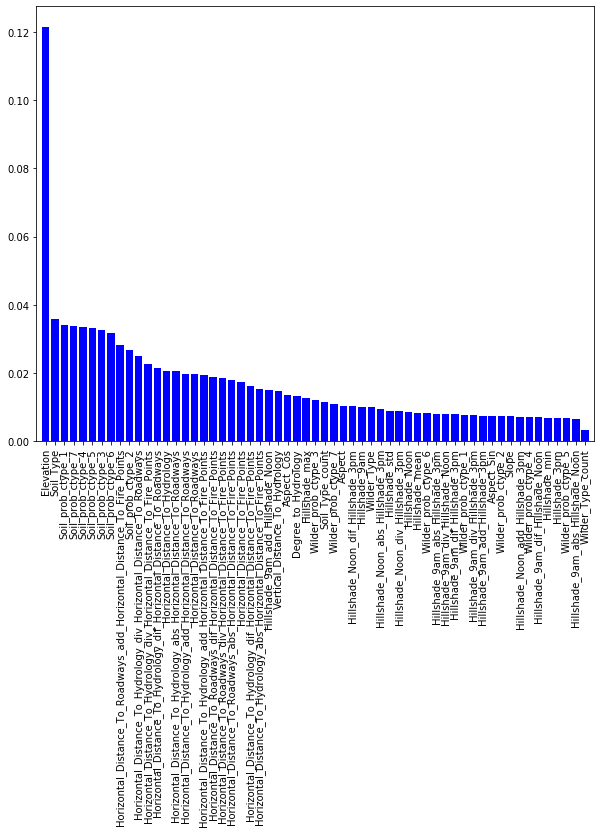

In [112]:
imp_ = rf_clf_imp_check.feature_importances_
features = X.columns.values
indices = np.argsort(imp_)[::-1]

plt.figure(figsize=(10,8))
plt.bar(range(len(indices)), imp_[indices], color = 'b', align='center')
plt.xticks(range(len(indices)), features[indices], rotation='vertical')
plt.xlim([-1,len(indices)])
plt.show()

In [113]:
#knn

all_set =  [['Elevation', 500],
            ['Horizontal_Distance_To_Roadways', 500],
            ['Horizontal_Distance_To_Fire_Points', 500],
            ['Horizontal_Distance_To_Hydrology', 500],
            ['Hillshade_9am', 500],
            ['Aspect', 500],
            ['Hillshade_3pm', 500],
            ['Slope', 500],
            ['Hillshade_Noon', 500],
            ['Vertical_Distance_To_Hydrology', 500],
            ['Elevation_PLUS_Vertical_Distance_To_Hydrology', 200],
            ['Elevation_PLUS_Hillshade_9am_add_Hillshade_Noon', 200],
            ['Elevation_PLUS_Aspect', 200],
            ['Elevation_PLUS_Hillshade_Noon_dif_Hillshade_3pm', 200],
            ['Elevation_PLUS_Hillshade_Noon_abs_Hillshade_3pm', 200],
            ['Elevation_PLUS_Hillshade_9am', 200],
            ['Elevation_PLUS_Horizontal_Distance_To_Hydrology', 200],
            ['Elevation_PLUS_Horizontal_Distance_To_Roadways', 100],
            ['Elevation_PLUS_Vertical_Distance_To_Hydrology', 200],
            ['Wilder_Type_PLUS_Elevation', 500],
            ['Wilder_Type_PLUS_Hillshade_Noon_div_Hillshade_3pm', 500],
            ['Wilder_Type_PLUS_Degree_to_Hydrology', 200],
            ['Wilder_Type_PLUS_Hillshade_9am_div_Hillshade_3pm', 500],
            ['Wilder_Type_PLUS_Aspect_Cos', 500],
            ['Hillshade_9am_dif_Hillshade_Noon_PLUS_Hillshade_Noon_dif_Hillshade_3pm', 200],
            ['Hillshade_Noon_PLUS_Hillshade_3pm', 200],
            ['Hillshade_Noon_add_Hillshade_3pm_PLUS_Hillshade_Noon_dif_Hillshade_3pm', 200]]


def simple_feature_scores2(clf, cols, test=False, **params):
    scores = []
    bscores = []
    lscores = []
    
    X_preds = np.zeros((len(y), 7))
    scl = StandardScaler().fit(X.loc[:, cols])
    
    for train, val in StratifiedKFold(n_splits=10, shuffle=True, random_state=2018).split(X, y):
        X_train = scl.transform(X.loc[train, cols])
        X_val = scl.transform(X.loc[val, cols])
        y_train = y[train]
        y_val = y[val]
        C = clf(**params) 

        C.fit(X_train, y_train)
        X_preds[val] = C.predict_proba(X_val)
        #scores.append(accuracy_score(y_val, C.predict(X_val)))
        #bscores.append(balanced_accuracy_score(y_val, C.predict(X_val)))
        #lscores.append(log_loss(y_val, C.predict_proba(X_val), labels=list(range(1, 8))))
    
    if test:
        X_test_select = scl.transform(X_test.loc[:, cols])
        C = clf(**params)
        C.fit(scl.transform(X.loc[:, cols]), y)
        X_test_preds = C.predict_proba(X_test_select)
    else:
        X_test_preds = None
    return scores, bscores, lscores, X_preds, X_test_preds

In [116]:
import warnings
import gc
from multiprocessing import Pool

warnings.filterwarnings("ignore")

preds = []
test_preds = []
for colname, neighbor in tqdm(all_set):
    gc.collect()
    #print(colname, depth)
    ts, tbs, ls, pred, test_pred = simple_feature_scores2(KNeighborsClassifier,
                                                          colname.split("_PLUS_"),
                                                          test=True,
                                                          n_neighbors=neighbor)
    preds.append(pred)
    test_preds.append(test_pred)

100%|██████████| 27/27 [35:07<00:00, 58.72s/it] 
